In [1]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots


In [2]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=2)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
res = 300                       # figure resolution (dpi)

300

In [3]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [4]:
out_path = joinpath(pwd(), "..", "..", "thesis")


"\\\\win.desy.de\\home\\muelderk\\My Documents\\MPC\\MPC_sim_Luna\\..\\..\\thesis"

## I) Read data from .h5 file

In [5]:
run = "run_2025_07_23__12_09_52"
run_path = joinpath("output", run)
save_figs = false

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))

    # Read beam waists
    global w_z_vac = read(file["w_z"]) 
    global w_min_vac = read(file["w_min"]) 
    global w_mirr_vac = read(file["w_mirr"]) 
    
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


In [6]:
run = "run_2025_06_04__00_45_47"
run_path = joinpath("output_thesis", run)
save_figs = true

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [7]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.20 - 0.50 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 4496.89, samples: 8192, δt = 333.56 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 1500.0 fs, actual time window: 2732.6 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 4096 / 8192, ωmax 4.71e+15 / 9.42e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## III) Analyze overall pulse evolution across all passes

In [8]:
Nr = length(r)
Nz = length(z)
Npass = length(w_min)

30

In [9]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

6030-element Vector{Float64}:
  0.0
  0.0019135454576426011
  0.0038270909152852022
  0.005740636372927804
  0.0076541818305704045
  0.009567727288213005
  0.011481272745855607
  0.013394818203498207
  0.015308363661140809
  0.01722190911878341
  ⋮
 11.465964382194466
 11.46787792765211
 11.469791473109751
 11.471705018567395
 11.473618564025037
 11.47553210948268
 11.477445654940322
 11.479359200397965
 11.481272745855607

### a) Beams Caustic 

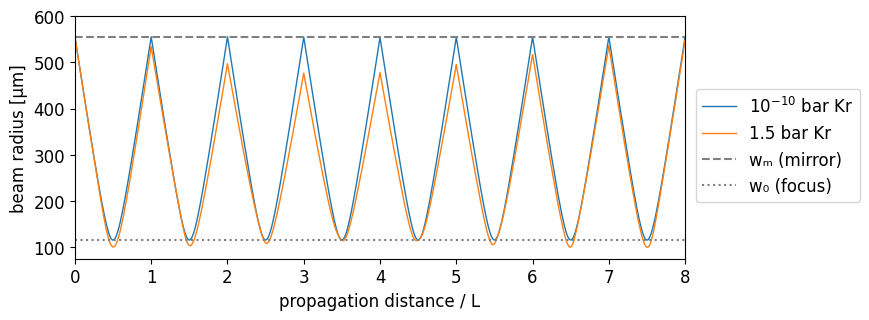

In [13]:
w0 = params["w0"]
wm = params["wm"]

plt.figure(figsize=size_py_wide)
plt.plot(z_total./L, w_z_vac*1e6, label="\$10^{-10}\$ bar Kr", linestyle="-", linewidth=1.0) #z_total*1e2
plt.plot(z_total./L, w_z*1e6, label="1.5 bar Kr", alpha=1.0, linewidth=1.0)
plt.axhline(y=wm*1e6, color="grey", linestyle="dashed", linewidth=1.5, label="wₘ (mirror)")
plt.axhline(y=w0*1e6, color="grey", linestyle="dotted", linewidth=1.5, label="w₀ (focus)")
plt.xlabel("propagation distance / L")
plt.ylabel("beam radius [μm]")
plt.xlim(0, 8)
plt.ylim(75, 600)
#plt.tight_layout()
plt.legend(loc="lower right", bbox_to_anchor=(1.30, 0.2))
if save_figs
    plt.savefig(joinpath(out_path, "caustic.pdf"), bbox_inches="tight", dpi=res)
end
plt.gcf()
    #plt.savefig(joinpath(out_path, "caustic_gas_vs_vac.png"), bbox_inches="tight", dpi=res)


### b) Minimum beam waist per pass

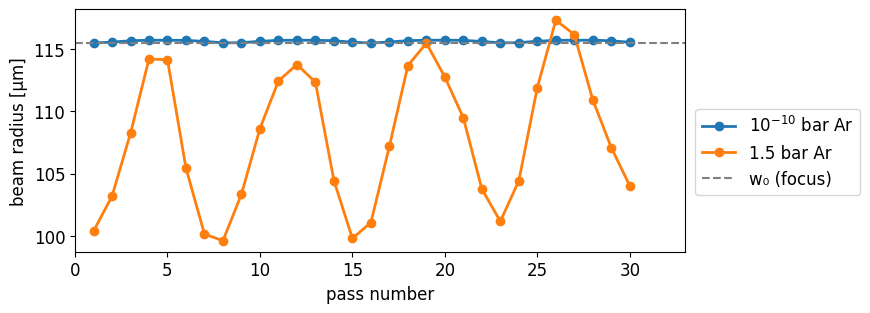

In [15]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py_wide) 
#plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min_vac.*1e6, marker="o", label="\$10^{-10}\$ bar Ar")
plt.plot(1:Npass, w_min.*1e6, marker="o", label="1.5 bar Ar")
plt.axhline(y=w0*1e6, color="grey", linewidth=1.5, linestyle="dashed", label="w₀ (focus)")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("beam radius [μm]")
plt.xlim(0,33)
# plt.ylim(95,)
plt.legend(loc="lower right", bbox_to_anchor=(1.30, 0.2))
if save_figs 
    plt.savefig(joinpath(out_path, "beam_waist_minimum.pdf"), dpi=res) 
end
plt.savefig(joinpath(out_path, "beam_waist_minimum.png"), bbox_inches="tight", dpi=res) 

plt.gcf()

### c) Mirror beam waist per pass

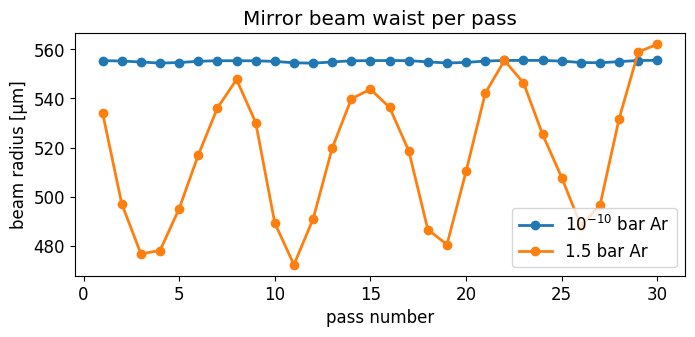

In [12]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py_wide) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr_vac.*1e6, marker="o", label="\$10^{-10}\$ bar Ar")
plt.plot(1:Npass, w_mirr.*1e6, marker="o", label="1.5 bar Ar")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("beam radius [μm]")
plt.legend()
if save_figs 
    plt.savefig(joinpath(out_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()